## Assignment 3 Question 2

Is it possible to predict ELO of a player based on context of a potential en passant move?

Only investigating the player who is in the position of making the en passant move.

Lila See FDS PCA solutions for 3 good points for what PCA is good for - include in report?

#### Import Libraries

In [17]:
import pandas as pd
import chess
import chess.pgn
import chess.engine
import io
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time

from pandarallel import pandarallel

import data_cleaning

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#### Import stockfish 🐟🐟🐟

In [18]:
# Windows installation
STOCKFISH_LOC = os.getcwd() + "\stockfish\stockfish-windows-2022-x86-64-avx2.exe"
# Unix based installation i.e. DICE/Codespaces
STOCKFISH_LOC_UNIX = os.getcwd() + "/stockfish_14_linux/stockfish_14_x64"

# Import stockfish package
from stockfish import Stockfish
# Try and read windows location
try:
    fish = Stockfish(path=STOCKFISH_LOC, depth=10, parameters={"Threads": 2, "Hash": 32})
    
# If error, read the linux location
except:
    fish = Stockfish(path=STOCKFISH_LOC_UNIX, depth=10, parameters={"Threads": 2, "Hash": 32})
    
# It will throw an error but if it still runs then ignore it :D

#### Import CSV file

66879 entries in dataframe

In [19]:
chess_data = data_cleaning.import_data()
print(chess_data.dtypes)

white_username    object
black_username    object
white_id          object
black_id          object
white_rating       int64
black_rating       int64
white_result      object
black_result      object
time_class        object
time_control      object
rules             object
rated               bool
fen               object
pgn               object
dtype: object


#### Dataframe info

Using:
print(chess_data.dtypes)
print(chess["rules"].unique())


Chess rules:
['chess' 'chess960' 'threecheck' 'crazyhouse' 'kingofthehill']

Time control:
['1/259200' '1/172800' '1800' '1/86400' '1/432000' '1/604800' '600'
 '120+1' '900+10' '300' '180+2' '3600+5' '2700+45' '3600' '1/1209600'
 '180' '600+10' '60' '480+3' '300+5' '420+3' '600+5' '600+2' '1200' '30'
 '60+1' '120' '1500+3' '900+2' '1500+5' '1500+10' '1/864000' '900' '300+2'
 '1500' '7200' '300+1' '5400' '3600+60' '2700+30' '3480+45' '10' '2700+10'
 '15' '2700' '3600+20' '4500' '4200' '900+5' '1800+10' '2700+5' '480+5'
 '1800+30' '300+3' '600+1' '1800+5' '420+5' '5400+30' '240+10' '420' '303'
 '60+10']

 Time class:
['daily' 'rapid' 'bullet' 'blitz']

#### Clean data

Undeveloped board shouldn't matter if we're filtering games for potential ep

Same for draws

Can filter our time class if are looking at time controls

After making a new move_list column, should we drop the pgn column?


Variables we are considering when predicting ELO (for a player who could potentially make en passant move) are: (Y = DONE, N = NOT DONE)
- Y: Colour who had ep opportunity (boolean)
- Y: Did they take the en passant? (boolean)
- N: Does their choice on taking/not taking support them if gaining an advantage? (numerical value for how much of an advantage it gives)
- N: Time taken to decide to capture/not capture en passant (... whatever can be time, a number in seconds ig)
- Y: Is the game rated? (boolean)
- Y: Game time class


To do:
- Work out which colour is making the potential en passant move, add a column to dataframe detailing this
- Make dataframe columns for other variables
- Apply PCA reduction

In [20]:
# Save PGN column from dataframe
full_pgn = chess_data['pgn']

def get_moves(entry):
    '''
    Retrive series of moves in a game when given the whole full_pgn entry
    '''
    pgn = entry.splitlines()[-1]
    return pgn

# Add list of moves (string) as a new column to dataframe
chess_data['move_list'] = full_pgn.apply(get_moves)
# Drop irrelevant columns
chess_data = chess_data.drop(['time_control', 'white_username', 'black_username','white_id', 'black_id', 'white_result', 'black_result', 'rules'], axis=1)

In [21]:
print(chess_data.iloc[0])

white_rating                                                 1708
black_rating                                                 1608
time_class                                                  daily
rated                                                        True
fen             r2r4/p2p1p1p/b6R/n1p1kp2/2P2P2/3BP3/PP5P/4K2R ...
pgn             [Event "Enjoyable games 2 - Round 1"]\n[Site "...
move_list       1. d4 Nf6 2. c4 e6 3. Nc3 Bb4 4. Qb3 Bxc3+ 5. ...
Name: 0, dtype: object


#### Import chess info
https://python-chess.readthedocs.io/en/latest/core.html#chess.Board.san


#### En Passant functions
- has_legal_en_passant() tests if en passant capturing would actually be possible on the next move.
- has_pseudo_legal_en_passant()
- has_legal_en_passant()
- is_en_passant(move: Move) Checks if the given pseudo-legal move is an en passant capture.




Use StringIO to parse games from a string.

```python
import io
pgn = io.StringIO("1. e4 e5 2. Nf3 *")
game = chess.pgn.read_game(pgn)
```

#### Clean data specifically for ep

Filter out columns that don't have potential ep
Add columns for: whether ep happened, which colour had potential to take ep

In [52]:
def check_pgn(df_row):
    import io
    import chess
    import chess.pgn
    
    '''
    Checks PGN for whether opportunity for EP happened in the game.
    '''
    
    pgn_file = io.StringIO(df_row["pgn"])   # PGN as a file
    game = chess.pgn.read_game(pgn_file)    # Read PGN and put into game
    board = game.board()                    # "board" of a game
    # pre-initialise df_row values
    precheck = False
    moved = False
    move_colour = ""
    
    time1 = ""
    time2 = ""
    time3 = ""
    
    # comparison sets when checking move piece
    ep_set = set(["ax","bx","cx","dx","ex","fx","gx", "hx"])
    check_set = set("abcdefgh")
    
    # Find only pawn moves in game
    for i, board_move in enumerate(game.mainline()):
        move = board_move.move
        san = board.san(move)
        turn = board.turn
        move_piece = san[0]
        # check if precheck was flagged in previous move
        if precheck:
            print(board_move.clock())
            # get first 2 letters, and compare to a set
            move_ep_piece = san[:2]
            if move_ep_piece in ep_set:
                # check if e.p. actually happened
                moved = board.is_en_passant(move)
            # break out for loop, no need to check further
            break
        
        # if the move was a pawn (lower case)
        if move_piece in check_set:
            # Push the move before checking the board
            board.push(move)
            # check if the next move can be en passant
            precheck = board.has_legal_en_passant()
            # if precheck is true then set the turn
            if precheck:
                print(board_move.clock())
                
                if turn:
                    move_colour = 'Black'
                else:
                    move_colour = 'White'
        # if the move wasn't a pawn then just continue as normal
        else:
            board.push(move)
    
    # set row values
    df_row["ep_opportunity"] = precheck
    df_row["ep_happened"] = moved
    df_row["ep_colour"] = move_colour
    return df_row

# chess_filter = chess_data[chess_data["time_class"] != "daily"].sample(100).copy(deep=True)
chess_filter = chess_data[chess_data["time_class"] != "daily"].sample(100).copy(deep=True)
chess_filter = chess_filter
# pandarallel.initialize()

start = time.time()
# apply e.p. finding function
# chess_filter = chess_filter.parallel_apply(check_pgn, axis=1)
chess_filter = chess_filter.apply(check_pgn, axis=1)
end = time.time()
print(end - start)

949.1


TypeError: 'Mainline' object is not subscriptable

In [23]:
chess_filter = chess_filter[chess_filter['ep_opportunity'] == True]
chess_filter = chess_filter.drop(['ep_opportunity'], axis=1)
chess_filter = chess_filter[chess_filter['time_class'] != "daily"]
chess_filter = chess_filter.reset_index(drop=True)
print(len(chess_filter))
print(len(chess_filter[chess_filter['ep_happened'] == True]))
# print(chess_filter["move_list"].sample(50).head(20))

5074
1563


In [24]:
# print(chess_filter.values)

In [25]:
# samp = chess_filter.sample(1000)

#### Cleaning data for EP - Advantage for ep

Analysing game - finding if ep move would have given an edvantage


Split into cases: ep happened and ep didn't happen


NOT DONE YET

In [26]:
def increment_letter(letter):
    '''dumb increment function'''
    if letter == "h":
        return "z"
    return chr(ord(letter) + 1)

def decrement_letter(letter):
    '''dumb decrement function'''
    if letter == "a":
        return "y"
    return chr(ord(letter) - 1)

def check_adjacent_piece(square, pawn):
    '''Checks if a piece on a square is an opponent pawn'''
    piece = fish.get_what_is_on_square(square)
    return True if piece == pawn else False

def get_abs_advantage(post, pre, col):
    '''Centipawns is always from white side so account for that'''
    difference = post - pre
    if col=="White":
        return difference
    else:
        return difference * -1
        

def get_best_move_evaluation(pre_eval, col):
    best_move = fish.get_best_move()
    # print("best move: " + str(best_move))
    
    ep_best = False
    if fish.will_move_be_a_capture(best_move) == fish.Capture.EN_PASSANT:
        ep_best = True
    
    # make best move and measure
    fish.make_moves_from_current_position([best_move])
    post_eval = fish.get_evaluation()
    # print("post-evaluation: " + str(post_eval["value"]))
    
    post_eval_best_diff = get_abs_advantage(post_eval["value"], pre_eval["value"], col)

    # print("post-evaluation diff: " + str(post_eval_best_diff))
    # print("----")
    return [post_eval_best_diff, ep_best]

def get_adj_squares(board, col, last_move):
    # column in the form "a - g"
    pawn_move_col = last_move[-2]
    # row in the form "1 - 8"
    pawn_move_row = last_move[-1]
    left_sq = decrement_letter(pawn_move_col) + pawn_move_row
    right_sq = increment_letter(pawn_move_col) + pawn_move_row
    return [left_sq, right_sq]
    
def check_valid_pawn(board, col, bounds, squares):
    left_bound, right_bound = bounds
    left_square, right_square = squares
    
    # if colour is white, we are looking for a white pawn
    if col == "White":
        FISH_PAWN = fish.Piece.WHITE_PAWN
    # if colour is black, we are looking for a black pawn
    else:
        FISH_PAWN = fish.Piece.BLACK_PAWN

    # set the fen
    fish.set_fen_position(board.fen())
    # print(fish.get_board_visual())
    # if corresponding square is a pawn of correct colour
    valid_left = False
    valid_right = False
    # if somewhere in the middle then check both sides
    if (not left_bound) and (not right_bound):
        valid_left = check_adjacent_piece(left_square, FISH_PAWN)
        valid_right = check_adjacent_piece(right_square, FISH_PAWN)
    
    # if pawn is on A file (leftmost)
    elif left_bound:
        # check right only
        valid_right = check_adjacent_piece(right_square, FISH_PAWN)
    
    # if pawn is on H file (rightmost)
    elif right_bound:
        # check left only
        valid_left = check_adjacent_piece(left_square, FISH_PAWN)
    
    return valid_left, valid_right

def ep_eval(fen, move, col):
    # reset board to pre-move FEN
    fish.set_fen_position(fen)
    # print(fish.get_board_visual())
    # make the move on stockfish
    fish.make_moves_from_current_position([move])
    
    # print(fish.get_board_visual())
    val = fish.get_evaluation()["value"]
    # print("e.p. evaluation: " + str(val))
    return val


def stockfish_analyse_board(df_row, board):
    col = df_row["ep_colour"]
    # print(col)
    
    fish.set_fen_position(board.fen())
    
    # get pre-move evaluation
    pre_eval = fish.get_evaluation()
    # print(pre_eval)
    # print("pre-evaluation: " + str(pre_eval["value"]))

    # use stockfish to get the best move, and the resulting evaluation
    post_eval_best_diff, ep_best = get_best_move_evaluation(pre_eval, col)
    
    # if the best move is e.p. then return immediately
    if ep_best:
        return [pre_eval, post_eval_best_diff, post_eval_best_diff]
    
    # e.g. "e7e5"
    last_move = str(board.peek())
    
    # get adjacent squares of the pre-e.p. move
    squares = get_adj_squares(board, col, last_move)
    left_square, right_square = squares
    # checks the move is in leftmost or rightmost column
    left_bound = True if left_square[-2] == "y" else False
    right_bound = True if right_square[-2] == "z" else False
    bounds = [left_bound, right_bound]
    ep_left, ep_right = check_valid_pawn(board, col, bounds, squares)
    
    # if white is attacking then e.p. on row 6
    # if black is attacking then e.p. on row 3
    resulting_row = "6" if col == "White" else "3"
    
    eval_ep_left = 0
    eval_ep_right = 0
    
    if ep_left and ep_right:
        move_left = decrement_letter(last_move[-2]) + last_move[-1] + last_move[-2] + resulting_row
        eval_ep_left = ep_eval(board.fen(), move_left, col)
        
        move_right = increment_letter(last_move[-2]) + last_move[-1] + last_move[-2] + resulting_row
        eval_ep_left = ep_eval(board.fen(), move_right, col)

        if col == "White":
            best_ep_val = max(eval_ep_left, eval_ep_right)
        else:
            best_ep_val = min(eval_ep_left, eval_ep_right)
        
    if ep_right:
        move = increment_letter(last_move[-2]) + last_move[-1] + last_move[-2] + resulting_row
        best_ep_val = ep_eval(board.fen(), move, col)
    else:
        move = decrement_letter(last_move[-2]) + last_move[-1] + last_move[-2] + resulting_row
        best_ep_val = ep_eval(board.fen(), move, col)
    
    # print(col)
    # print("pre: " + str(pre_eval["value"]))
    # print("best: " + str(best_ep_val))
    if col == "White":
        post_eval_ep_diff = best_ep_val - pre_eval["value"]
        # print("diff: " + str(post_eval_ep_diff))
    else:
        post_eval_ep_diff = -1*(best_ep_val - pre_eval["value"])
        # print("diff: " + str(post_eval_ep_diff))
    # print()

    
    return [pre_eval, post_eval_best_diff, post_eval_ep_diff]

def get_advantage(df_row):
    check_set = set("abcdefgh")
    # print(df_row.name)
    
    pgn_file = io.StringIO(df_row["pgn"])   # PGN as a file
    game = chess.pgn.read_game(pgn_file)    # Read PGN and put into game
    board = game.board()                    # "board" of a game
    precheck = False
    
    pre_eval = 0
    post_eval_best_diff = 0
    post_eval_ep_diff = 0
    
    for move in game.mainline_moves():
        san = board.san(move)
        move_piece = san[0]

        # check if precheck was flagged in previous move
        if precheck:
            precheck = False
            # colour is the colour of the player with the opportunity
            values = stockfish_analyse_board(df_row, board)
            pre_eval = values[0]
            post_eval_best_diff = values[1]
            post_eval_ep_diff = values[2]
            break
            
            
        # if the move was a pawn (lower case)
        if move_piece in check_set:
            # Push the move before checking the board
            board.push(move)
            # check if the next move can be en passant
            precheck = board.has_legal_en_passant()
        # if the move wasn't a pawn then just continue as normal
        else:
            board.push(move)

    if precheck:
        # colour is the colour of the player with the opportunity
        values = stockfish_analyse_board(df_row, board)
        pre_eval = values[0]
        post_eval_best_diff = values[1]
        post_eval_ep_diff = values[2]
    
    df_row["pre_state"] = pre_eval["value"]
    df_row["state_best"] = post_eval_best_diff# stockfish eval if e.p. is taken
    df_row["state_ep"] = post_eval_ep_diff # stockfish eval if e.p. isn't taken
    return df_row

# samp3 = get_advantage(samp.loc[2011])
# print(samp3)
chess_filter = chess_filter.apply(get_advantage, axis=1)

In [27]:
print(len(chess_filter[(chess_filter["state_best"] == chess_filter["state_ep"]) & (chess_filter["ep_happened"] == True)]))

818


### Number of games with at least 1 possible en-passant move - ???:
## 4750
(maybe 4913 or even 4945)

### Number of games with an actual en-passant move - ???:
## 1566

#### Applying PCA


In [28]:


# Replace Boolean and string variables with numbers
chess_filter['ep_happened'] = chess_filter['ep_happened'].replace({True:1, False:0})
chess_filter['ep_colour'] = chess_filter['ep_colour'].replace({'White':1, 'Black':0})
chess_filter['rated'] = chess_filter['rated'].replace({True:1, False:0})
chess_filter['time_class'] = chess_filter['time_class'].replace({'daily':3, 'rapid':2, 'blitz':1, 'bullet':0})

# Drop irrelevant columns, and save differently - as a dataframe including the rating and one without
chess_data_with_elo = chess_filter.drop(['fen', 'pgn', 'move_list', 'time_class', 'rated'], axis=1)
chess_data_without_elo = chess_data_with_elo.drop(['white_rating', 'black_rating'], axis=1)

# chess_data_without_elo["eval_diff"] = chess_data_without_elo["state_best"] - chess_data_without_elo["state_ep"]
# chess_data_without_elo = chess_data_without_elo.drop(['state_best', 'state_ep'], axis=1)

# chess_data_with_elo["eval_diff"] = chess_data_with_elo["state_best"] - chess_data_with_elo["state_ep"]
# chess_data_with_elo = chess_data_with_elo.drop(['state_best', 'state_ep'], axis=1)


chess_data_without_elo["diff_with_best"] = chess_data_without_elo["state_best"] + chess_data_without_elo["pre_state"]
chess_data_without_elo["diff_with_ep"] = chess_data_without_elo["state_ep"] + chess_data_without_elo["pre_state"]
chess_data_with_elo["diff_with_best"] = chess_data_with_elo["state_best"] + chess_data_with_elo["pre_state"]
chess_data_with_elo["diff_with_ep"] = chess_data_with_elo["state_ep"] + chess_data_with_elo["pre_state"]

chess_data_without_elo = chess_data_without_elo.drop(['state_best', 'state_ep', 'pre_state'], axis=1)
chess_data_with_elo = chess_data_with_elo.drop(['state_best', 'state_ep', 'pre_state'], axis=1)




print(chess_data_with_elo.head())
print('\n')
print(chess_data_without_elo.head())

   white_rating  black_rating  ep_happened  ep_colour  diff_with_best  \
0          1498          1540            0          1             178   
1          1505          1485            1          0              -3   
2          1239          1177            0          0            -435   
3          1485          1531            1          0            -827   
4          1536          1523            1          0             394   

   diff_with_ep  
0           184  
1             0  
2          -695  
3          -827  
4           394  


   ep_happened  ep_colour  diff_with_best  diff_with_ep
0            0          1             178           184
1            1          0              -3             0
2            0          0            -435          -695
3            1          0            -827          -827
4            1          0             394           394


##### Data Standardisation (For PCA)

Cite week 8 lab sheet in report? Heavily used their code to help

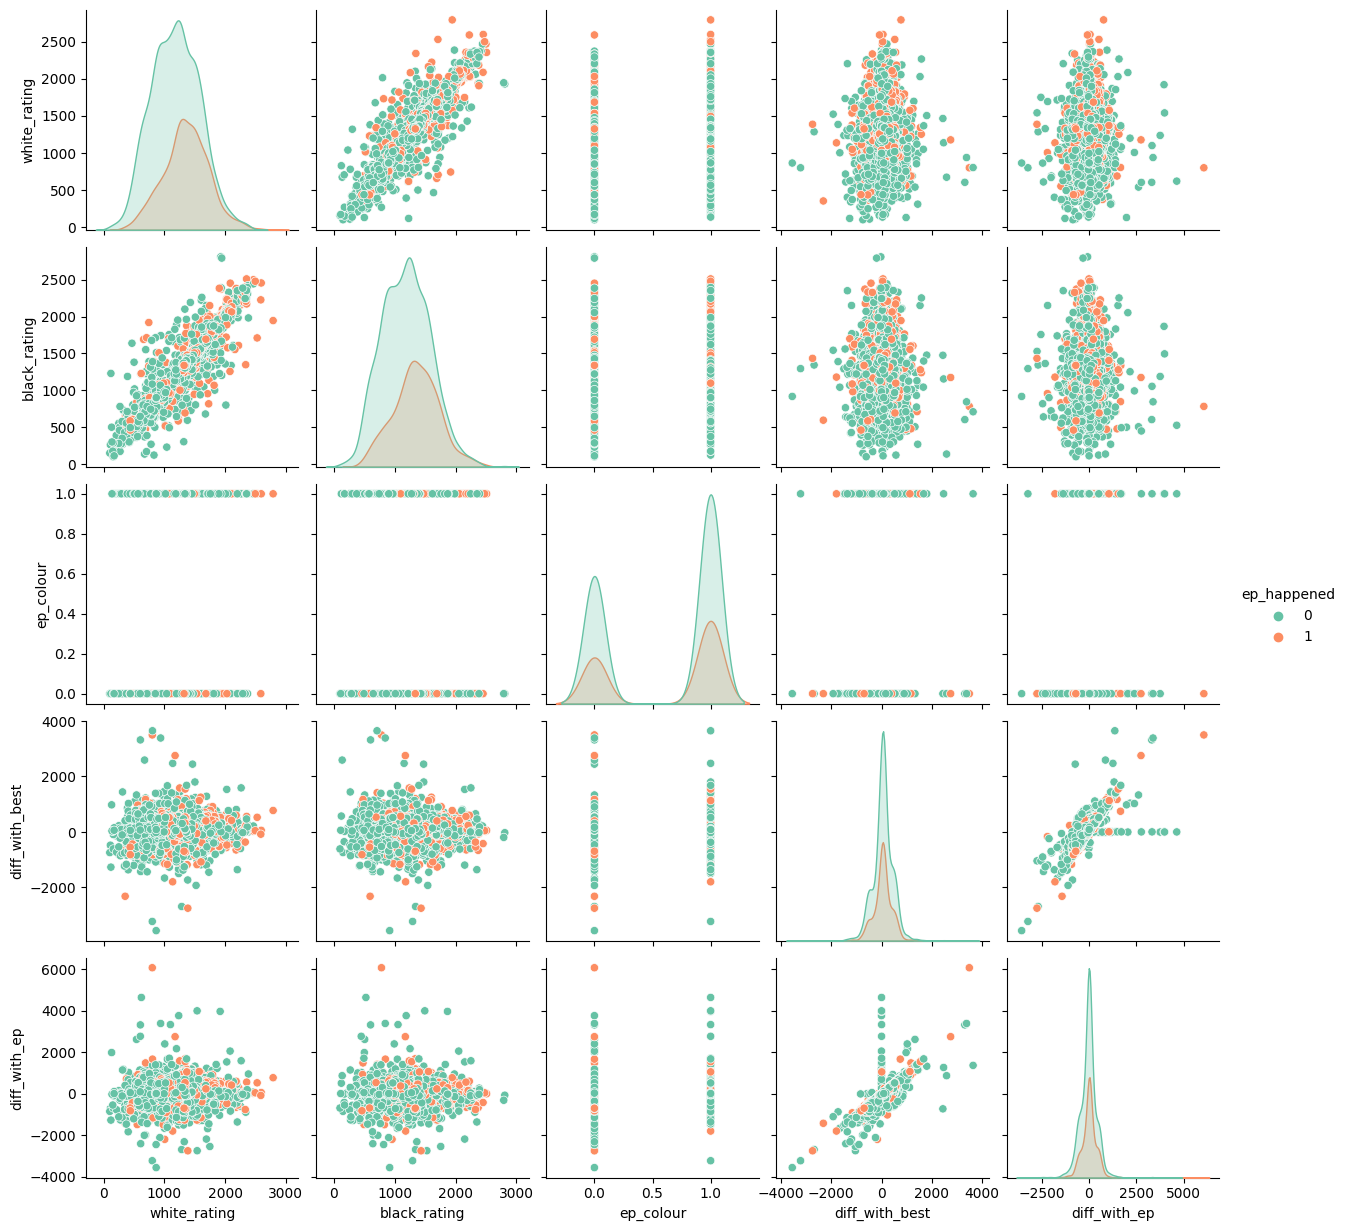

In [32]:
# THIS PART IS COPIED AND PASTED FROM WEEK 8 PCA SOLUTIONS:
def sort_eigenvalues(eigenvalues, eigenvectors):
    idx = eigenvalues.argsort()[::-1]   
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]
    return eigenvalues, eigenvectors

# THE REST IS HEAVILY INFLUENCED BY WEEK 8 PCA SOLUTIONS

# Standardise chess_data_without_elo so that it follows the Standard normal distribution
for col in chess_data_without_elo.columns:
        chess_data_without_elo[col] = (chess_data_without_elo[col] - chess_data_without_elo[col].mean()) / chess_data_without_elo[col].std()

# # Create matrix storing covariances of the chess dataframe features
# covariances = np.cov(chess_data_without_elo.values.T)

# # Record eigenvalues and eigenvectors
# eigenvalues, eigenvectors = np.linalg.eig(covariances)
# eigenvalues, eigenvalues = sort_eigenvalues(eigenvalues, eigenvectors)

# result = chess_data_without_elo.dot(eigenvectors[:,:2])

# sns.scatterplot(x= result[0], y = result[1], hue=diagnosis)
# plt.xlabel('PC1')
# plt.ylabel('PC2')

def standardize(df):
    standardized = pd.DataFrame()
    for col in df.columns: # We can apply mathematical operation to entire columns at once, as they are built on top of numpy arrays
        standardized[col] = (df[col]-df[col].mean())/df[col].std() #For each column move the data s.t. it is centered around 0 and has variance=1
    return standardized


sns.pairplot(hue='ep_happened', data=chess_data_with_elo, palette="Set2")

# # Lila Can we instead use this? :
# standardise = stan
# pca = PCA(n_components=5).fit(chess_data_without_elo.values)
# pca_result = pca.transform(chess_data_without_elo.values)
# sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=)
# plt.xlabel('PC1')
# plt.ylabel('PC2')

Text(0, 0.5, 'PC2')

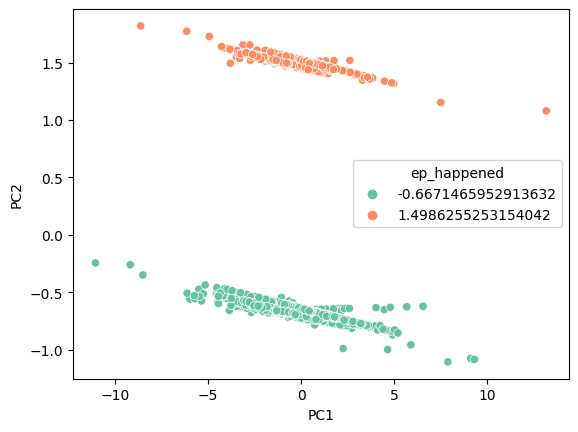

In [31]:
ep_happened_result = chess_data_without_elo["ep_happened"]

standardized = standardize(chess_data_without_elo)
pca = PCA(n_components=4).fit(standardized.values)
pca_result = pca.transform(standardized.values)
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=ep_happened_result, palette="Set2")
plt.xlabel('PC1')
plt.ylabel('PC2')